**Impor Library & Mount Google Drive**

In [19]:
# Impor library yang diperlukan
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import numpy as np
import random
import matplotlib.pyplot as plt # Untuk visualisasi grafik

# PENTING: Pastikan 'files' ada di sini untuk fungsi unggah gambar
from google.colab import drive, files

print("Library berhasil diimpor.")

# Mount Google Drive
print("Menghubungkan ke Google Drive...")
drive.mount('/content/drive')
print("Google Drive berhasil terhubung.")

Library berhasil diimpor.
Menghubungkan ke Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive berhasil terhubung.


**Ekstraksi Dataset**

In [20]:
# --- Konfigurasi Lokasi Dataset ZIP ---
# **** PENTING: PATH INI SUDAH DISESUAIKAN DENGAN LOKASI FILE ZIP ANDA ****
# Berdasarkan informasi Anda: 'My Drive/Datasets/dataset.zip'
PATH_TO_YOUR_ZIP = '/content/drive/MyDrive/Datasets/dataset.zip'

# Folder tujuan ekstraksi di lingkungan Colab. Direkomendasikan di /content/
EXTRACT_TO_DIR = '/content/fer2013_dataset_extracted'

print(f"Mengekstrak dataset dari '{PATH_TO_YOUR_ZIP}' ke '{EXTRACT_TO_DIR}'...")

# Buat folder tujuan jika belum ada.
!mkdir -p {EXTRACT_TO_DIR}

# Ekstrak file ZIP.
!unzip -q {PATH_TO_YOUR_ZIP} -d {EXTRACT_TO_DIR}

print("Ekstraksi selesai.")

# --- Verifikasi Struktur Folder (Opsional) ---
print("\nMemverifikasi struktur folder setelah ekstraksi:")
!ls -F {EXTRACT_TO_DIR}

print("\nIsi contoh folder Training:")
!ls -F {os.path.join(EXTRACT_TO_DIR, 'Training')}

print("\nIsi contoh folder Testing:")
!ls -F {os.path.join(EXTRACT_TO_DIR, 'Testing')}

Mengekstrak dataset dari '/content/drive/MyDrive/Datasets/dataset.zip' ke '/content/fer2013_dataset_extracted'...
replace /content/fer2013_dataset_extracted/Testing/Testing/Angry/Angry-1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Ekstraksi selesai.

Memverifikasi struktur folder setelah ekstraksi:
Testing/  Training/

Isi contoh folder Training:
Training/

Isi contoh folder Testing:
Testing/


 **Pra-pemrosesan Data dengan ImageDataGenerator**

In [23]:
# --- Konfigurasi Parameter Gambar & Direktori ---
# Direktori tempat dataset diekstrak. Mengambil dari variabel di sel sebelumnya.
# Ini adalah folder utama setelah ekstraksi, yaitu '/content/fer2013_dataset_extracted'
BASE_DIR_EXTRACTED = EXTRACT_TO_DIR

# Pastikan path ini menunjuk ke folder *terdalam* yang berisi folder-folder emosi.
# Berdasarkan output Anda sebelumnya, strukturnya adalah 'Training/Training' dan 'Testing/Testing'
TRAIN_DIR = os.path.join(BASE_DIR_EXTRACTED, 'Training', 'Training')
TEST_DIR = os.path.join(BASE_DIR_EXTRACTED, 'Testing', 'Testing')

# Verifikasi keberadaan direktori sebelum melanjutkan
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"ERROR: Direktori training tidak ditemukan di: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"ERROR: Direktori testing tidak ditemukan di: {TEST_DIR}")

# Parameter gambar yang akan digunakan oleh model CNN
IMG_HEIGHT = 48 # Resolusi gambar FER-2013
IMG_WIDTH = 48
BATCH_SIZE = 64 # Jumlah gambar yang akan diproses per batch (saat training/inference)

# **** PENTING: REVISI INI ****
# Karena dataset Anda hanya memiliki 6 kelas (Angry, Fear, Happy, Neutral, Sad, Suprise)
# Kita sesuaikan NUM_CLASSES menjadi 6.
NUM_CLASSES = 6

print(f"Direktori pelatihan (yang benar): {TRAIN_DIR}")
print(f"Direktori pengujian (yang benar): {TEST_DIR}")
print(f"Ukuran gambar target: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"Ukuran batch: {BATCH_SIZE}")
print(f"Jumlah kelas emosi: {NUM_CLASSES}") # Sekarang akan mencetak 6

# --- Inisialisasi ImageDataGenerator ---
# Untuk data pelatihan: Normalisasi piksel (0-255 ke 0-1) DAN Data Augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalisasi piksel
    rotation_range=10,       # Rotasi gambar secara acak (derajat)
    width_shift_range=0.1,   # Geser gambar horizontal secara acak (fraksi dari lebar)
    height_shift_range=0.1,  # Geser gambar vertikal secara acak (fraksi dari tinggi)
    shear_range=0.1,         # Shear transformation
    zoom_range=0.1,          # Zoom gambar secara acak
    horizontal_flip=True,    # Balik gambar secara horizontal secara acak
    fill_mode='nearest'      # Cara mengisi piksel yang kosong setelah transformasi
)

# Untuk data pengujian: HANYA Normalisasi piksel (tidak ada augmentasi)
test_datagen = ImageDataGenerator(rescale=1./255)

# --- Membuat Data Generator dari Direktori ---
# Generator ini akan membaca gambar langsung dari folder dan menyiapkannya untuk model
print("\nMembuat generator data pelatihan...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Semua gambar akan diresize ke ukuran ini
    batch_size=BATCH_SIZE,
    color_mode='grayscale', # Gambar FER-2013 adalah grayscale (saluran tunggal)
    class_mode='categorical' # Label akan diubah menjadi one-hot encoding
)

print("\nMembuat generator data pengujian...")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False # Untuk pengujian, biasanya tidak perlu mengacak urutan data
)

# Menampilkan mapping kelas emosi ke indeks numerik yang digunakan oleh model
emotion_labels = dict((v, k) for k, v in train_generator.class_indices.items())
print("\nMapping Emosi ke Indeks Numerik:", emotion_labels)

Direktori pelatihan (yang benar): /content/fer2013_dataset_extracted/Training/Training
Direktori pengujian (yang benar): /content/fer2013_dataset_extracted/Testing/Testing
Ukuran gambar target: 48x48
Ukuran batch: 64
Jumlah kelas emosi: 6

Membuat generator data pelatihan...
Found 28273 images belonging to 6 classes.

Membuat generator data pengujian...
Found 7067 images belonging to 6 classes.

Mapping Emosi ke Indeks Numerik: {0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Suprise'}


In [21]:
from sklearn.utils import class_weight
import numpy as np

print("Menghitung bobot kelas untuk mengatasi ketidakseimbangan dataset...")

# Dapatkan indeks kelas dari generator pelatihan
y_train_indices = train_generator.classes

# Hitung bobot kelas menggunakan strategi 'balanced'
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_indices),
    y=y_train_indices
)

# Ubah array bobot menjadi dictionary sesuai format yang dibutuhkan Keras
class_weights = dict(enumerate(class_weights_array))

print("Bobot kelas yang dihitung:")
print(class_weights)

print("\nBobot kelas per emosi:")
for idx, weight in class_weights.items():
    print(f"- {emotion_labels[idx]}: {weight:.2f}")

# Verifikasi: Pastikan jumlah bobot kelas sesuai dengan NUM_CLASSES
if len(class_weights) != NUM_CLASSES:
    print(f"Peringatan: Jumlah bobot kelas ({len(class_weights)}) tidak sesuai dengan NUM_CLASSES ({NUM_CLASSES}).")
    print("Pastikan NUM_CLASSES di Sel 3 sudah disesuaikan menjadi 6.")

Menghitung bobot kelas untuk mengatasi ketidakseimbangan dataset...
Bobot kelas yang dihitung:
{0: np.float64(1.1795160617438465), 1: np.float64(1.1501505166381905), 2: np.float64(0.6531069531069531), 3: np.float64(0.9490768714333669), 4: np.float64(0.9756038647342995), 5: np.float64(1.486019131714496)}

Bobot kelas per emosi:
- Angry: 1.18
- Fear: 1.15
- Happy: 0.65
- Neutral: 0.95
- Sad: 0.98
- Suprise: 1.49


**Membangun Model Convolutional Neural Network (CNN)**

In [9]:
print("Membangun arsitektur model CNN...")
model = Sequential([
    # Lapisan Konvolusi Pertama
    # 32 filter, ukuran kernel 3x3, aktivasi ReLU.
    # input_shape adalah dimensi gambar yang akan diterima model (48x48 piksel, 1 channel untuk grayscale).
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    # MaxPooling2D mengurangi dimensi spasial, membantu mengurangi komputasi dan overfitting.
    MaxPooling2D((2, 2)),

    # Lapisan Konvolusi Kedua
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Dropout: Secara acak 'mematikan' beberapa neuron selama training untuk mencegah overfitting.
    Dropout(0.25),

    # Lapisan Konvolusi Ketiga
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten: Mengubah output 2D/3D dari lapisan konvolusi menjadi vektor 1D
    # agar bisa diumpankan ke lapisan Dense (fully connected).
    Flatten(),

    # Lapisan Dense (Fully Connected) Pertama
    Dense(256, activation='relu'), # 256 neuron
    Dropout(0.5), # Dropout tambahan

    # Lapisan Output
    # Jumlah neuron = NUM_CLASSES (7 emosi).
    # 'softmax': Fungsi aktivasi untuk klasifikasi multi-kelas, menghasilkan probabilitas untuk setiap kelas
    # (jumlah total probabilitas = 1). Kelas dengan probabilitas tertinggi adalah prediksi model.
    Dense(NUM_CLASSES, activation='softmax')
])

# Kompilasi Model
# optimizer='adam': Algoritma yang digunakan untuk mengoptimalkan bobot model selama training.
# loss='categorical_crossentropy': Fungsi loss yang digunakan untuk mengukur 'kesalahan' model
#       saat memprediksi label one-hot encoded.
# metrics=['accuracy']: Metrik yang akan dipantau selama training untuk melihat performa model.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Model CNN berhasil dibangun.")
# Menampilkan ringkasan arsitektur model (jumlah lapisan, output shape, jumlah parameter).
model.summary()

Membangun arsitektur model CNN...
Model CNN berhasil dibangun.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 618,758 (2.36 MB)

 Trainable params: 618,758 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

**Melatih Model (Training)**

Memulai pelatihan model...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


441/441 ━━━━━━━━━━━━━━━━━━━━ 66s 146ms/step - accuracy: 0.2025 - loss: 1.7618 - val_accuracy: 0.3088 - val_loss: 1.6614
Epoch 2/100
  1/441 ━━━━━━━━━━━━━━━━━━━━ 47s 108ms/step - accuracy: 0.2656 - loss: 1.7079

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


441/441 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.2656 - loss: 1.7079 - val_accuracy: 0.3082 - val_loss: 1.6757
Epoch 3/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 82s 185ms/step - accuracy: 0.3103 - loss: 1.6351 - val_accuracy: 0.4135 - val_loss: 1.4727
Epoch 4/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3906 - loss: 1.5607 - val_accuracy: 0.4267 - val_loss: 1.4489
Epoch 5/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 64s 146ms/step - accuracy: 0.3932 - loss: 1.5247 - val_accuracy: 0.4743 - val_loss: 1.3366
Epoch 6/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5469 - loss: 1.2778 - val_accuracy: 0.4740 - val_loss: 1.3338
Epoch 7/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 78s 146ms/step - accuracy: 0.4290 - loss: 1.4527 - val_accuracy: 0.5082 - val_loss: 1.2839
Epoch 8/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5000 - loss: 1.3545 - val_accuracy: 0.5087 - val_loss: 1.2833
Epoch 9/100
441/441 ━━━━━━━━━━━━━━━━━━━━ 79s 148ms/step - accuracy: 0.4540 - loss: 1.4041 - val_ac

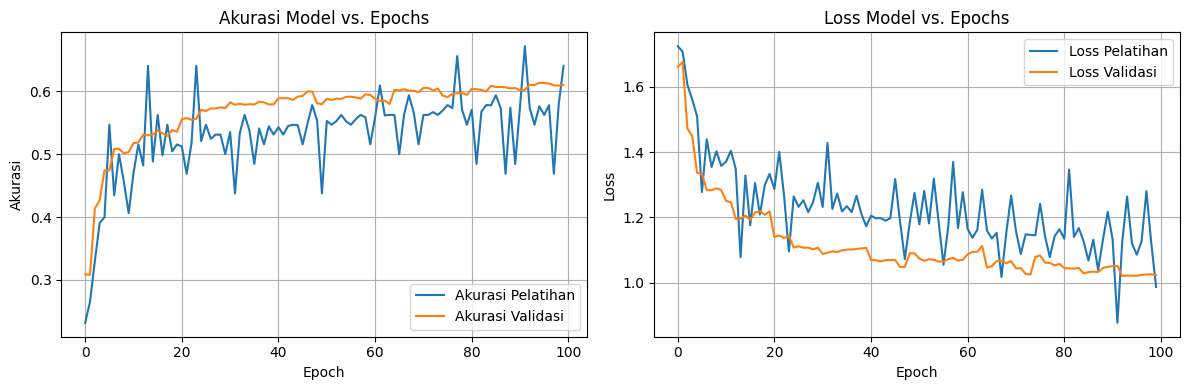

In [22]:
print("Memulai pelatihan model...")
STEPS_PER_EPOCH = train_generator.samples // BATCH_SIZE
VALIDATION_STEPS = test_generator.samples // BATCH_SIZE

history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=100, # Anda bisa mencoba 150 atau 200 jika akurasi masih kurang
    validation_data=test_generator,
    validation_steps=VALIDATION_STEPS,
    class_weight=class_weights # **** PENTING: INI ADALAH TAMBAHAN UNTUK class_weight ****
)

print("\nPelatihan model selesai.")

# --- Visualisasi Hasil Pelatihan ---
print("Menampilkan grafik akurasi dan loss pelatihan...")
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Evaluasi Model & Fungsi Prediksi**

In [30]:
print("Mengevaluasi model pada data pengujian akhir...")
# Evaluasi model pada test_generator untuk mendapatkan akurasi akhir.
loss, accuracy = model.evaluate(test_generator)
print(f'Akurasi Model pada Data Pengujian Akhir: {accuracy*100:.2f}%')

# --- Fungsi untuk Memprediksi Ekspresi dari Gambar Tunggal ---
def predict_emotion_from_image(image_path, model, emotion_labels, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    """
    Memuat sebuah gambar dari path, memprosesnya agar sesuai format input model,
    dan memprediksi ekspresi wajah di dalamnya.

    Args:
        image_path (str): Path lengkap ke file gambar.
        model (keras.Model): Model CNN yang sudah dilatih.
        emotion_labels (dict): Dictionary mapping indeks numerik ke nama emosi (dari train_generator.class_indices).
        img_height (int): Tinggi gambar target (default 48).
        img_width (int): Lebar gambar target (default 48).

    Returns:
        str: Nama emosi yang diprediksi atau pesan error.
    """
    try:
        # Muat gambar, resize ke target_size, dan konversi ke grayscale
        img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width), color_mode='grayscale')
        # Konversi gambar ke array NumPy
        img_array = tf.keras.utils.img_to_array(img)
        # Tambahkan dimensi batch (model mengharapkan input (batch_size, height, width, channels))
        # Jadi dari (48,48,1) menjadi (1,48,48,1)
        img_array = np.expand_dims(img_array, axis=0)
        # Normalisasi piksel ke rentang 0-1 (harus sama seperti saat pelatihan)
        img_array /= 255.0

        # Lakukan prediksi menggunakan model
        predictions = model.predict(img_array)
        # Ambil indeks kelas dengan probabilitas tertinggi dari hasil prediksi
        predicted_class_index = np.argmax(predictions[0])
        # Konversi indeks numerik ke nama emosi menggunakan dictionary emotion_labels
        predicted_emotion = emotion_labels[predicted_class_index]

        return predicted_emotion

    except Exception as e:
        return f"Error saat memproses gambar atau memprediksi: {e}"

Mengevaluasi model pada data pengujian akhir...
111/111 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5664 - loss: 1.0933
Akurasi Model pada Data Pengujian Akhir: 61.07%


**Rekomendasi Musik Berdasarkan Prediksi Ekspresi Wajah (dengan Fitur Unggah)**


--- Sistem Rekomendasi Musik Interaktif ---
Silakan **UNGGAH** gambar wajah Anda untuk mendapatkan rekomendasi musik.
Pastikan gambar hanya mengandung satu wajah dan ekspresinya terlihat jelas.


Saving Neutral.jpg to Neutral (1).jpg

File 'Neutral (1).jpg' berhasil diunggah.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

--- Hasil Analisis Wajah ---
Ekspresi wajah yang terdeteksi: **NEUTRAL**


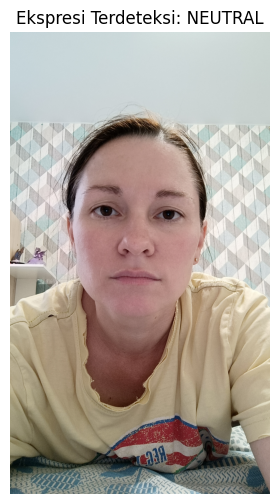


Berdasarkan mood 'NEUTRAL', saya merekomendasikan playlist ini:
- Jazz Instrumental.mp3
- Chill Pop Background.mp3
- Classical Piano (Calm Piano)

(Anda bisa mencari lagu-lagu ini di platform musik favorit Anda!)

--- Proyek selesai! ---


In [29]:
# --- Daftar Rekomendasi Musik Berdasarkan Emosi ---
# KUNCI (KEY) DI DICTIONARY INI HARUS SAMA PERSIS DENGAN NAMA EMOSI YANG TERDETEKSI OLEH MODEL (dari output Sel 3):
# 'Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Suprise'
# Perhatikan kapitalisasi huruf awal pada setiap nama emosi.

music_recommendations = {
    'Angry': [
        "Linkin Park - Numb (Nu Metal)", "Rage Against The Machine - Killing In The Name (Rap Metal)",
        "System Of A Down - Chop Suey!.mp3", "Bring Me The Horizon - Can You Feel My Heart.mp3",
        "Heavy Metal Riff.mp3"
    ],
    'Fear': [
        "Hans Zimmer - Time (Inception Soundtrack - Ambient/Tense)", "Trent Reznor & Atticus Ross - Hand Covers Bruise (Social Network Soundtrack - Ambient/Dark)",
        "Dark Ambient Track.mp3", "Suspenseful Classical.mp3", "Eerie Soundscape.mp3"
    ],
    'Happy': [
        "Pharrell Williams - Happy (Upbeat Pop)", "Bruno Mars - Uptown Funk (Funk/Pop)",
        "Queen - Don't Stop Me Now (Rock Anthem)", "Katty Perry - Roar.mp3",
        "Optimistic Instrumental.mp3"
    ],
    'Neutral': [
        "Lo-fi Hip Hop Beats (Relaxing/Study)", "Ambient Study Music (Chill Instrumental)",
        "Jazz Instrumental.mp3", "Chill Pop Background.mp3",
        "Classical Piano (Calm Piano)"
    ],
    'Sad': [
        "Adele - Someone Like You (Ballad)", "Billie Eilish - Ocean Eyes (Indie Pop)",
        "Radiohead - Creep (Alternative Rock)", "Bon Iver - Skinny Love.mp3",
        "Lewis Capaldi - Someone You Loved.mp3"
    ],
    'Suprise': [ # Perhatikan: 'Suprise' (bukan 'Surprise') sesuai dengan deteksi ImageDataGenerator
        "Avicii - Levels (Electronic Dance)", "Daft Punk - One More Time (House/Dance)",
        "Clean Bandit ft. Jess Glynne - Rather Be.mp3", "Upbeat Jazz Fusion.mp3",
        "Experimental Pop - Unexpected Sounds.mp3"
    ]
}

# --- Fungsi Rekomendasi Musik Utama ---
def recommend_playlist_by_face(image_path, model, emotion_labels, music_recommendations_dict):
    """
    Mendeteksi emosi dari gambar wajah yang diunggah dan merekomendasikan playlist musik.
    Juga akan menampilkan gambar yang diunggah beserta hasil prediksinya.
    """
    predicted_emotion = predict_emotion_from_image(image_path, model, emotion_labels)

    if "Error" in predicted_emotion:
        print(predicted_emotion)
        return

    print(f"\n--- Hasil Analisis Wajah ---")
    print(f"Ekspresi wajah yang terdeteksi: **{predicted_emotion.upper()}**")

    # --- Tampilkan Gambar yang Diunggah ---
    try:
        img_display = tf.keras.utils.load_img(image_path, color_mode='rgb') # Muat dalam mode RGB untuk display warna
        plt.figure(figsize=(6, 6))
        plt.imshow(img_display)
        plt.title(f"Ekspresi Terdeteksi: {predicted_emotion.upper()}") # Judul plot dengan ekspresi
        plt.axis('off') # Sembunyikan sumbu
        plt.show() # Tampilkan plot
    except Exception as e:
        print(f"Gagal menampilkan gambar: {e}")

    # Rekomendasi lagu berdasarkan emosi yang terdeteksi
    if predicted_emotion in music_recommendations_dict:
        playlist = music_recommendations_dict[predicted_emotion]
        recommended_songs = random.sample(playlist, min(3, len(playlist)))
        print(f"\nBerdasarkan mood '{predicted_emotion.upper()}', saya merekomendasikan playlist ini:")
        for i, song in enumerate(recommended_songs):
            print(f"- {song}")
        print("\n(Anda bisa mencari lagu-lagu ini di platform musik favorit Anda!)")
    else:
        print("\nMaaf, tidak ada rekomendasi musik spesifik untuk ekspresi ini.")
        print("Pastikan nama emosi yang terdeteksi ada dalam daftar rekomendasi Anda.")

# --- Bagian Pengujian Interaktif dengan Unggah File ---
print("\n--- Sistem Rekomendasi Musik Interaktif ---")
print("Silakan **UNGGAH** gambar wajah Anda untuk mendapatkan rekomendasi musik.")
print("Pastikan gambar hanya mengandung satu wajah dan ekspresinya terlihat jelas.")

uploaded_files = files.upload() # Membuka dialog unggah file

if uploaded_files:
    for filename in uploaded_files.keys():
        image_path_to_analyze = f'/content/{filename}'
        print(f"\nFile '{filename}' berhasil diunggah.")
        recommend_playlist_by_face(image_path_to_analyze, model, emotion_labels, music_recommendations)
else:
    print("\nTidak ada gambar yang diunggah. Mohon unggah gambar untuk memulai.")

print("\n--- Proyek selesai! ---")